<a href="https://colab.research.google.com/github/JosephAFerguson/DeepLearningFinalProj/blob/main/DeepLearningJF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json, time, os
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from requests import Session
from sklearn.preprocessing import MinMaxScaler

In [2]:
# ----------------------------
# 1. CoinMarketCap API Helper
# ----------------------------
class CryptoEndpoint:
    listingsEndpoint = "https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest"
    latestQuotes = "https://pro-api.coinmarketcap.com/v2/cryptocurrency/quotes/latest"
    historicalQuotes = "https://pro-api.coinmarketcap.com/v2/cryptocurrency/quotes/historical"

    def __init__(self, apikey) -> None:
        self.headers = {
            'Accepts': 'application/json',
            'X-CMC_PRO_API_KEY': apikey,
        }
        self.coinsInfo = {}
        self.coinsIds = []

    def GetCoinIdentifiers(self, limit=10):
        session = Session()
        session.headers.update(self.headers)
        response = session.get(
            url=self.listingsEndpoint,
            params={"limit": limit, "price_min": 1, "price_max": 20}
        )

        if response.status_code != 200:
            raise Exception(f"Error fetching listings: {response.text}")

        data = json.loads(response.text)

        for coin in data.get("data", []):
            self.coinsInfo[coin["name"]] = coin["id"]
            self.coinsIds.append(coin["id"])

        print(f"Loaded {len(self.coinsInfo)} coins.")
        return (self.coinsInfo, self.coinsIds)

    def GetSampleCoinHistoricalData(self, coin_id, days=60):
        """Fetch historical daily prices for one coin."""
        session = Session()
        session.headers.update(self.headers)

        end_time = datetime.utcnow()
        start_time = end_time - timedelta(days=days)

        params = {
            "id": coin_id,
            "time_start": start_time.isoformat(),
            "time_end": end_time.isoformat(),
            "interval": "24h",
        }

        response = session.get(url=self.historicalQuotes, params=params)
        if response.status_code != 200:
            print(f"Error for coin {coin_id}: {response.text}")
            return []

        data = json.loads(response.text)
        if data.get("status", {}).get("error_code") != 0:
            print(f"API error for {coin_id}: {data['status']}")
            return []

        coin_data = data.get("data", {})
        quotes = coin_data.get("quotes", [])
        if not quotes:
            return []

        historicals = []
        for quote in quotes:
            price = quote["quote"]["USD"]["price"]
            volume = quote["quote"]["USD"]["volume_24h"]
            historicals.append([price, volume])

        return historicals

In [3]:
# ----------------------------
# 2. LSTM Model Definition
# ----------------------------
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out  # logits (for BCEWithLogitsLoss)

In [4]:
# ----------------------------
# 3. Data Preparation Utility
# ----------------------------
def prepare_sequences(data_dict, window=10):
    """
    Convert dict {coin_id: [[price, volume], ...]} into windowed tensors
    Target: 1 if next price > current, else 0
    """
    scaler = MinMaxScaler()
    X, Y, labels = [], [], []

    for coin_id, seq in data_dict.items():
        arr = np.array(seq)
        if len(arr) <= window + 1:
            continue
        scaled = scaler.fit_transform(arr)
        prices = arr[:, 0]

        for i in range(len(scaled) - window - 1):
            X.append(scaled[i:i+window])
            next_dir = 1.0 if prices[i+window+1] > prices[i+window] else 0.0
            Y.append(next_dir)
            labels.append(coin_id)

    X = torch.tensor(np.array(X), dtype=torch.float32)
    Y = torch.tensor(np.array(Y), dtype=torch.float32).view(-1, 1)
    return X, Y, labels

In [5]:
# ----------------------------
# 4. Training and Evaluation
# ----------------------------
def train_model(model, X, Y, epochs=100, lr=0.01):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)

        if (epoch + 1) % 10 == 0:
            pred = torch.sigmoid(outputs)
            acc = ((pred > 0.5) == (Y > 0.5)).float().mean().item()
            print(f"Epoch [{epoch+1}/{epochs}] | Loss: {loss.item():.5f} | Accuracy: {acc*100:.2f}%")

    return model

In [6]:
# ----------------------------
# 5. Get and Save Data as CSV
# ----------------------------
def GetSaveData():
    apikey = input("Enter your CoinMarketCap API key: ").strip()
    ce = CryptoEndpoint(apikey)

    data_dir = "data"
    os.makedirs(data_dir, exist_ok=True)

    # Optionally control how "fresh" the data should be before refetching
    freshness_days = 1  # re-download if older than this many days

    coinsInfo, coinsIds = ce.GetCoinIdentifiers(limit=10)
    print("Fetching historical data (or loading cached files)...")

    all_data = {}

    for coinId in coinsIds:
        file_path = os.path.join(data_dir, f"{coinId}.csv")

        # Check if we already have cached data
        if os.path.exists(file_path):
            modified_time = datetime.fromtimestamp(os.path.getmtime(file_path))
            if datetime.now() - modified_time < timedelta(days=freshness_days):
                print(f"[INFO] Using cached data for {coinId}")
                df = pd.read_csv(file_path)
                all_data[coinId] = df
                continue
            else:
                print(f"[INFO] Cached data for {coinId} is old. Refetching...")

        # Fetch new data from API
        hist = ce.GetSampleCoinHistoricalData(coinId, days=60)
        if len(hist) > 0:
            df = pd.DataFrame(hist)
            df.to_csv(file_path, index=False)
            print(f"[INFO] Saved new data for {coinId} → {file_path}")
            all_data[coinId] = df
        else:
            print(f"[WARN] No data found for {coinId}")

        time.sleep(2)  # Avoid hitting API rate limits

    print(f"\n✅ Fetched or loaded data for {len(all_data)} coins.")
    return all_data

Enter your CoinMarketCap API key: a76bd6fc-2b66-4a25-843f-321def3437bd
Loaded 10 coins.
Fetching historical data (or loading cached files)...


/tmp/ipython-input-2886719308.py:42: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_time = datetime.utcnow()


[INFO] Saved new data for 3408 → data/3408.csv
[INFO] Saved new data for 1975 → data/1975.csv
[INFO] Saved new data for 3957 → data/3957.csv
[INFO] Saved new data for 5805 → data/5805.csv
[INFO] Saved new data for 11419 → data/11419.csv
[INFO] Saved new data for 6636 → data/6636.csv
[INFO] Saved new data for 7083 → data/7083.csv
[INFO] Saved new data for 8916 → data/8916.csv
[INFO] Saved new data for 6535 → data/6535.csv
[INFO] Saved new data for 1321 → data/1321.csv

✅ Fetched or loaded data for 10 coins.
Samples: 480


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:1340: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  current = float(metrics)


Epoch [10/100] | Loss: 0.69004 | Accuracy: 51.67%
Epoch [20/100] | Loss: 0.67195 | Accuracy: 56.67%
Epoch [30/100] | Loss: 0.65316 | Accuracy: 59.79%
Epoch [40/100] | Loss: 0.63263 | Accuracy: 62.50%
Epoch [50/100] | Loss: 0.61588 | Accuracy: 63.54%
Epoch [60/100] | Loss: 0.59583 | Accuracy: 65.62%
Epoch [70/100] | Loss: 0.59610 | Accuracy: 65.62%
Epoch [80/100] | Loss: 0.58776 | Accuracy: 65.00%
Epoch [90/100] | Loss: 0.58282 | Accuracy: 66.46%
Epoch [100/100] | Loss: 0.57858 | Accuracy: 66.46%

Overall Accuracy: 67.29%


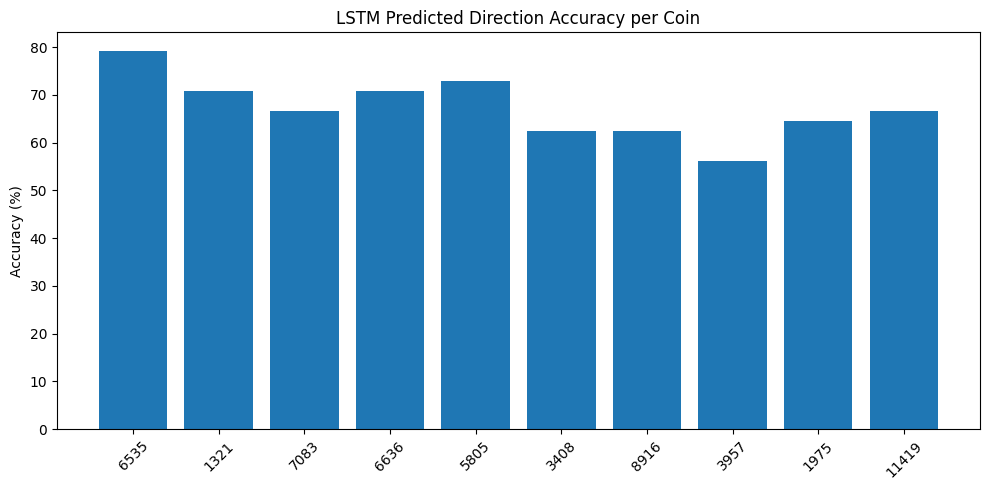

Done ✅


In [7]:
# ----------------------------
# 6. Main Execution
# ----------------------------
all_data = GetSaveData()

# Prepare training data
trainX, trainY, labels = prepare_sequences(all_data, window=10)
print(f"Samples: {len(trainX)}")

# Train model
model = LSTMModel(input_dim=2, hidden_dim=64, layer_dim=1, output_dim=1)
trained_model = train_model(model, trainX, trainY, epochs=100, lr=0.01)

# ----------------------------
# Evaluate per-coin accuracy
# ----------------------------
model.eval()
with torch.no_grad():
    preds = torch.sigmoid(model(trainX))
    preds_class = (preds > 0.5).float()
    actual = trainY
    overall_acc = (preds_class == actual).float().mean().item()

print(f"\nOverall Accuracy: {overall_acc*100:.2f}%")

unique_ids = list(set(labels))
per_coin_acc = []
for cid in unique_ids:
    idxs = [i for i, lbl in enumerate(labels) if lbl == cid]
    if len(idxs) == 0: continue
    acc = (preds_class[idxs] == actual[idxs]).float().mean().item()
    per_coin_acc.append((cid, acc))

# Plot per-coin direction accuracy
plt.figure(figsize=(10, 5))
plt.bar(range(len(per_coin_acc)), [x[1]*100 for x in per_coin_acc])
plt.xticks(range(len(per_coin_acc)), [str(x[0]) for x in per_coin_acc], rotation=45)
plt.ylabel("Accuracy (%)")
plt.title("LSTM Predicted Direction Accuracy per Coin")
plt.tight_layout()
plt.show()

print("Done ✅")